In [158]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

## Pre-processing

In [37]:
files_dir = "assignment_dataset/train/image"
labels_dir = "assignment_dataset/train/label"

files = os.listdir(files_dir)
labels = os.listdir(labels_dir)

In [36]:
processed_image_dir = "preprocessed/image"

for file in files:
    img = cv2.imread(os.path.join(files_dir,file))
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(processed_image_dir, file), img)

In [55]:
processed_label_dir = "preprocessed/label"

for label in labels:
    img = cv2.imread(os.path.join(labels_dir,label))
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(processed_label_dir, label), img)

#### Display preocessed images

/var/folders/hm/r5pwp4rs5zd7v5745srhxk7w0000gn/T/ipykernel_19575/1689449749.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)


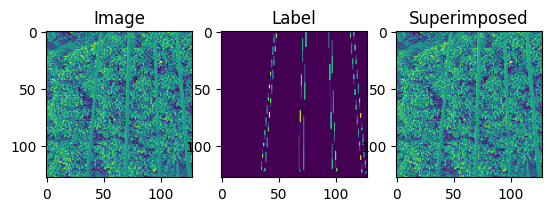

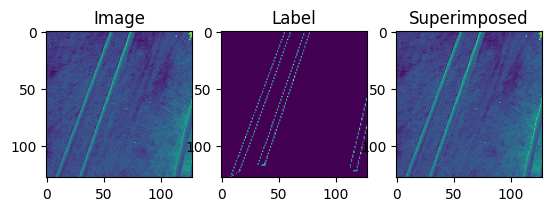

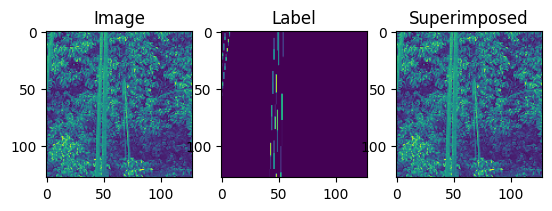

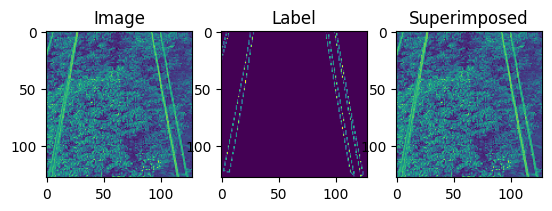

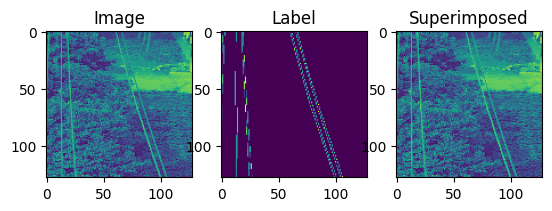

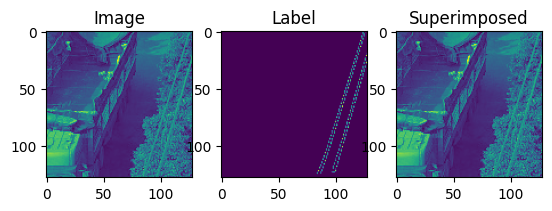

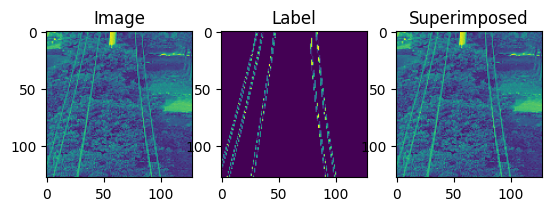

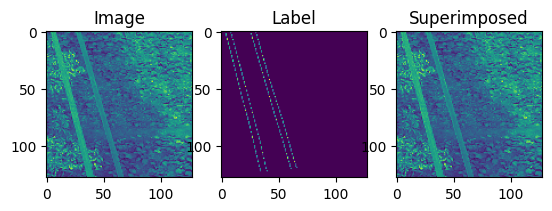

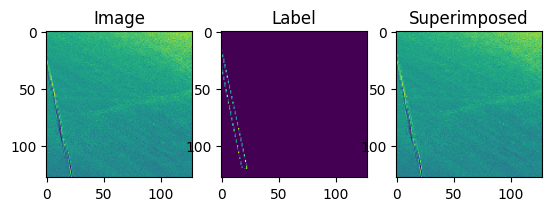

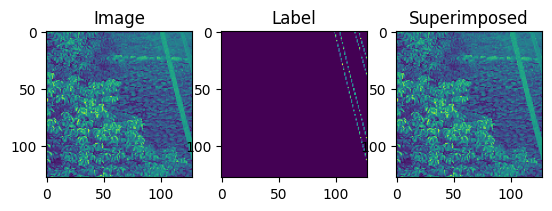

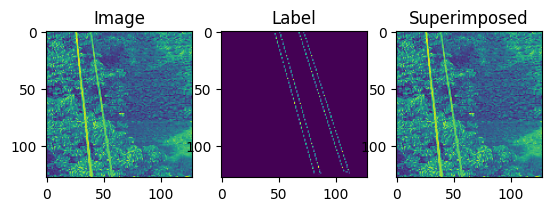

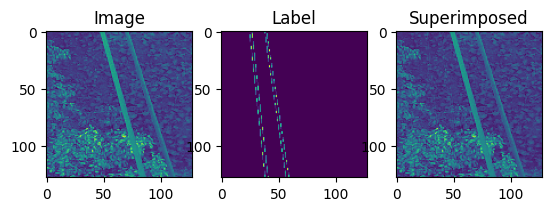

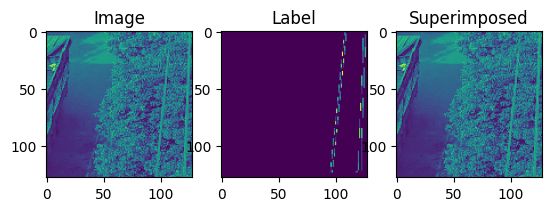

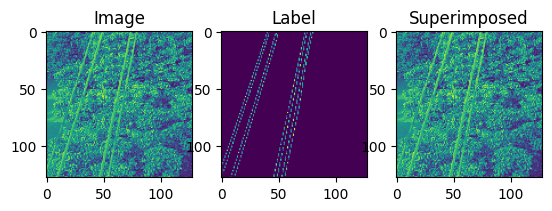

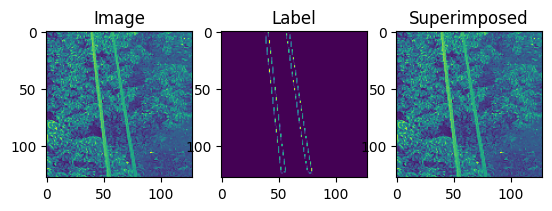

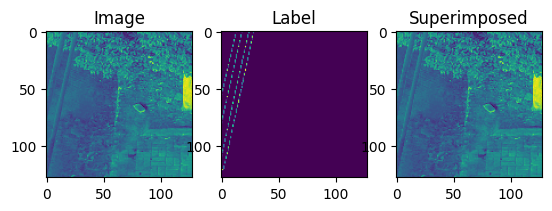

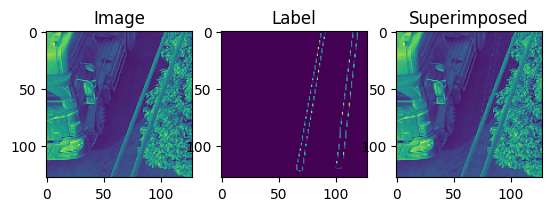

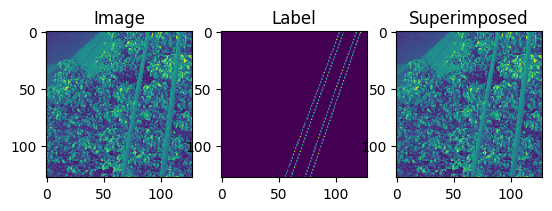

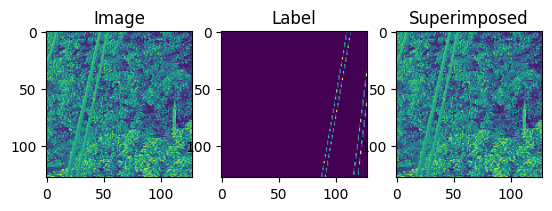

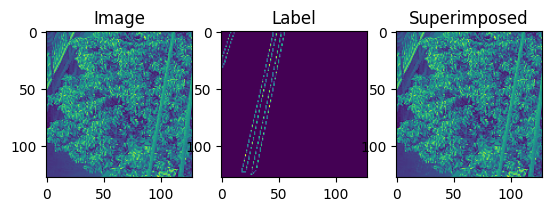

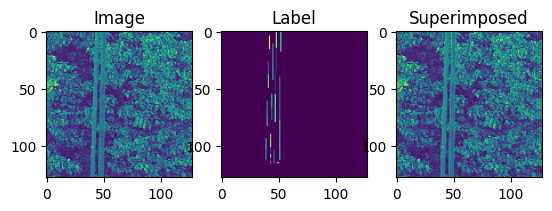

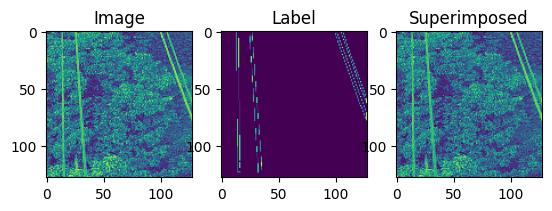

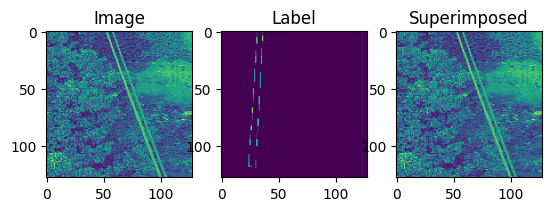

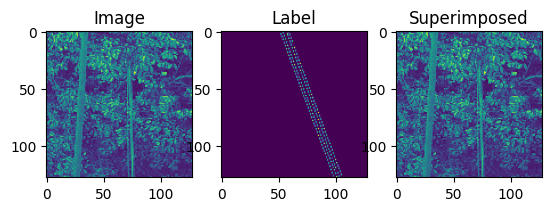

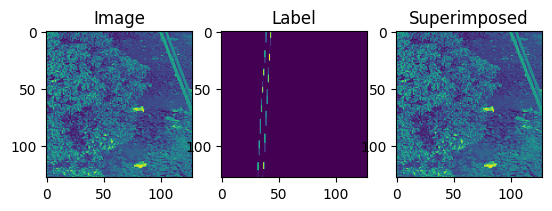

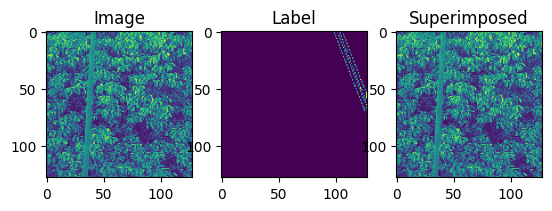

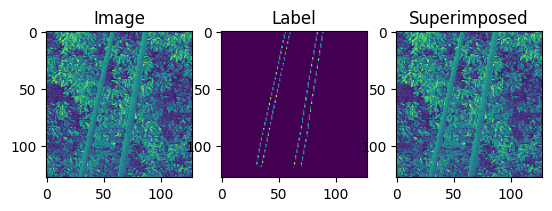

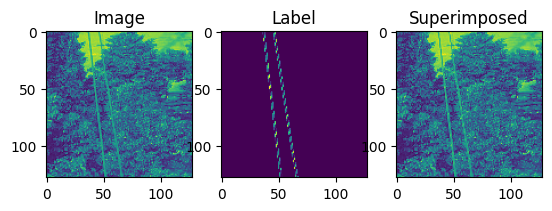

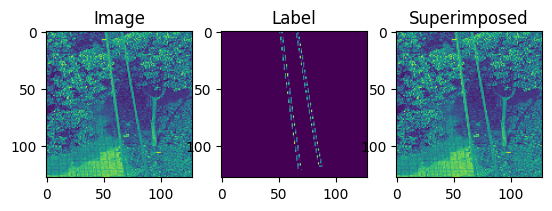

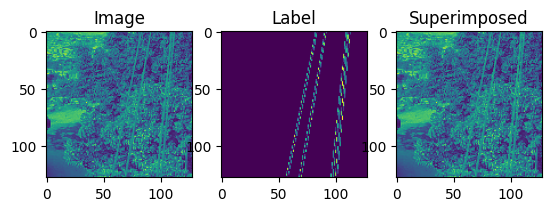

In [59]:
for file,label in zip(files,labels):
    img = cv2.imread(os.path.join(processed_image_dir,file), cv2.IMREAD_GRAYSCALE )
    label = cv2.imread(os.path.join(processed_label_dir,label), cv2.IMREAD_GRAYSCALE)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)

    overlay_image = cv2.addWeighted(img,1,label,.1,0)
    ax1.set_title("Image")
    ax1.imshow(img)
    ax2.set_title("Label")
    ax2.imshow(label)
    ax3.set_title("Superimposed")
    ax3.imshow(overlay_image)

## Modeling

#### Data split

In [175]:
X = []
y = []

for file,label in zip(files,labels):
    #img = cv2.imread(os.path.join(processed_image_dir,file) )
    img = cv2.imread(os.path.join(processed_image_dir,file), cv2.IMREAD_GRAYSCALE )
    #label = cv2.imread(os.path.join(processed_label_dir,label))
    label = cv2.imread(os.path.join(processed_label_dir,label), cv2.IMREAD_GRAYSCALE)

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

X = X/255.0
y = y/255.0
print(X.shape, y.shape)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(X.shape, y.shape)

(30, 128, 128) (30, 128, 128)
(30, 128, 128, 1) (30, 128, 128, 1)


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27, 128, 128, 1) (27, 128, 128, 1)
(3, 128, 128, 1) (3, 128, 128, 1)


#### Functions

In [166]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [167]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [168]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [180]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
# 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)

In [181]:
def build_unet_model():
    # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

#### Train

In [184]:
unet_model = build_unet_model()

unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=bce_dice_loss,
                  metrics=dice_coeff)

NUM_EPOCHS = 10

unet_model.fit(X_train, y_train,
                              epochs=NUM_EPOCHS, batch_size=10,
                              validation_split=0.1 )

Epoch 1/10
3/3 [==============================] - 5s 1s/step - loss: 1.5326 - dice_coeff: 0.0226 - val_loss: 1.2004 - val_dice_coeff: 0.0332
Epoch 2/10
3/3 [==============================] - 3s 965ms/step - loss: 1.1609 - dice_coeff: 0.0230 - val_loss: 1.0822 - val_dice_coeff: 0.0332
Epoch 3/10
3/3 [==============================] - 3s 943ms/step - loss: 1.0671 - dice_coeff: 0.0237 - val_loss: 1.0768 - val_dice_coeff: 0.0332
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 1.0655 - dice_coeff: 0.0232 - val_loss: 1.0758 - val_dice_coeff: 0.0332
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 1.0646 - dice_coeff: 0.0234 - val_loss: 1.0786 - val_dice_coeff: 0.0332
Epoch 6/10
3/3 [==============================] - 3s 935ms/step - loss: 1.0661 - dice_coeff: 0.0252 - val_loss: 1.0779 - val_dice_coeff: 0.0332
Epoch 7/10
3/3 [==============================] - 3s 864ms/step - loss: 1.0638 - dice_coeff: 0.0244 - val_loss: 1.0733 - val_dice_coeff: 0.0332
E

In [149]:
y_pred = unet_model.predict(X_test)

1/1 [==============================] - 0s 388ms/step


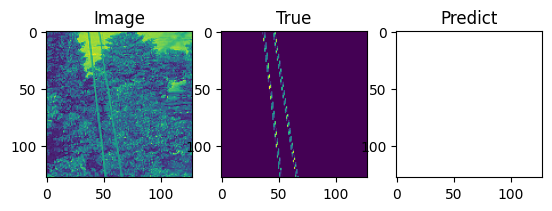

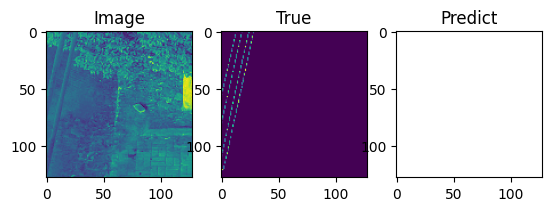

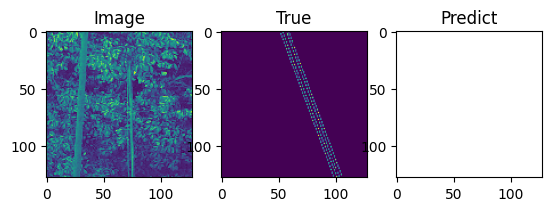

In [150]:
for x,y,pred in zip(X_test, y_test, y_pred):

    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.set_title("Image")
    ax1.imshow(x)
    ax2.set_title("True")
    ax2.imshow(y)
    ax3.set_title("Predict")
    ax3.imshow(pred)

In [151]:
y_train_pred = unet_model.predict(X_train)

1/1 [==============================] - 2s 2s/step


/var/folders/hm/r5pwp4rs5zd7v5745srhxk7w0000gn/T/ipykernel_19575/2825489878.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1,ax2,ax3) = plt.subplots(1,3)


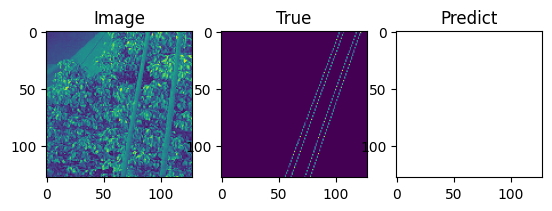

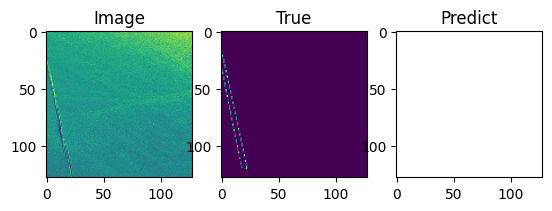

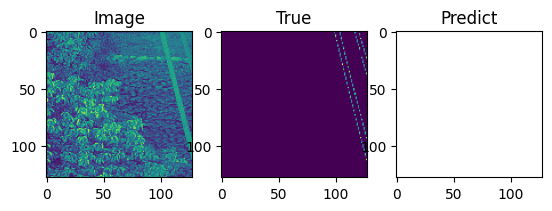

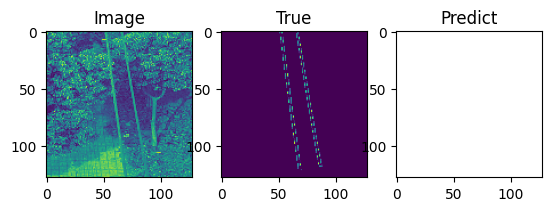

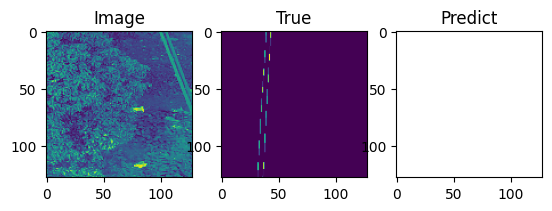

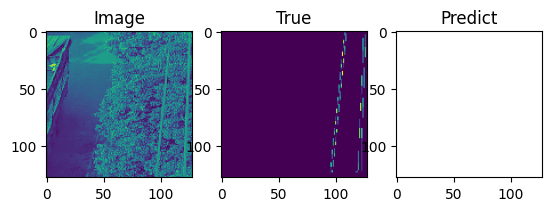

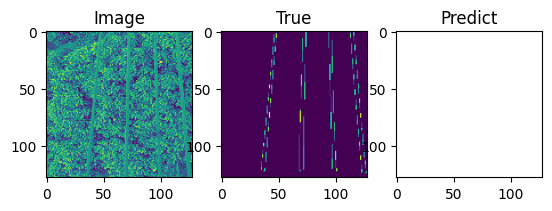

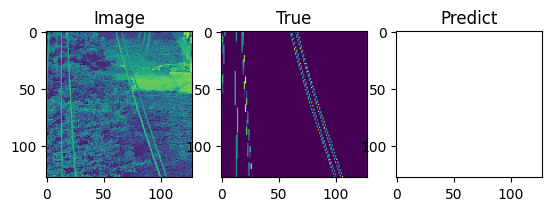

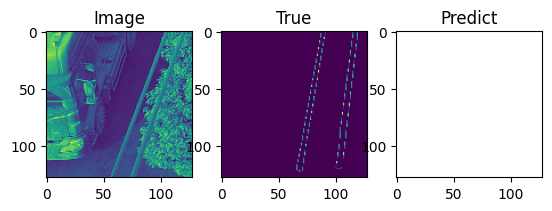

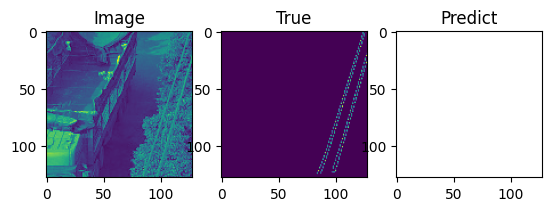

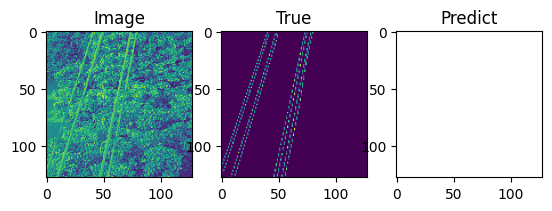

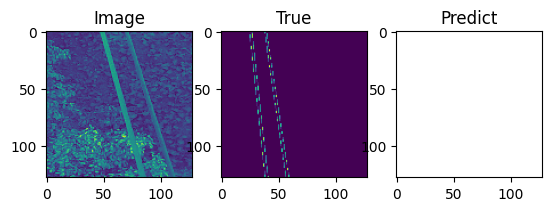

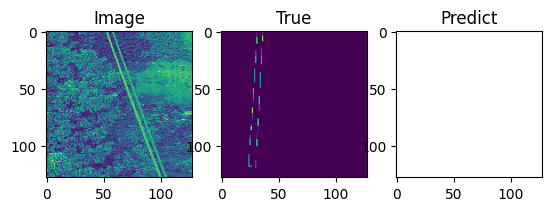

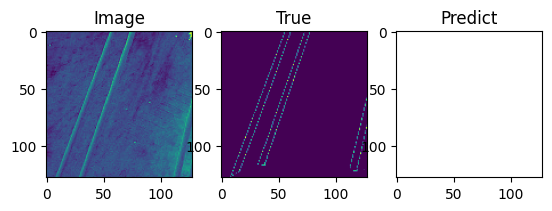

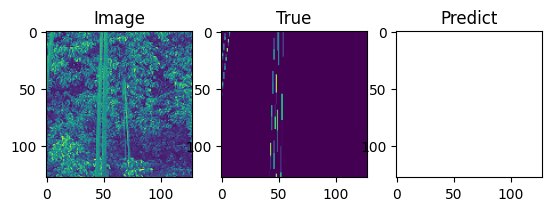

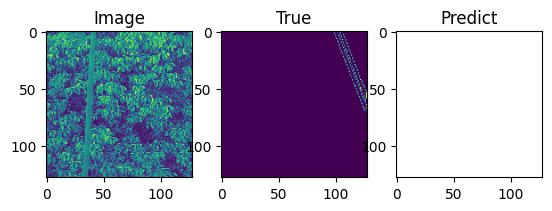

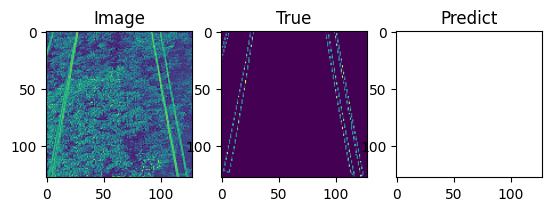

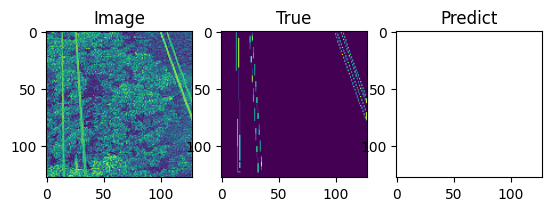

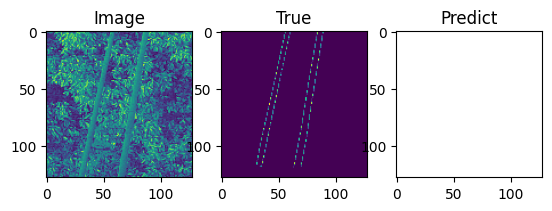

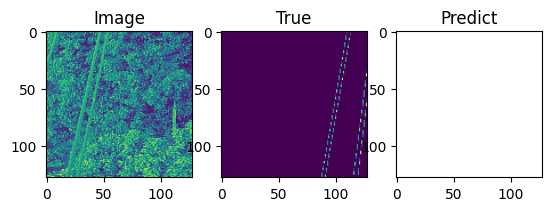

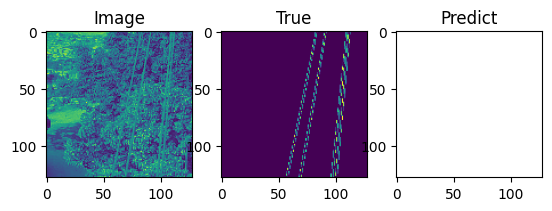

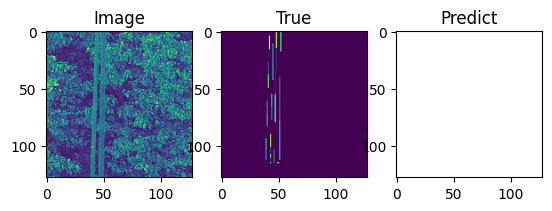

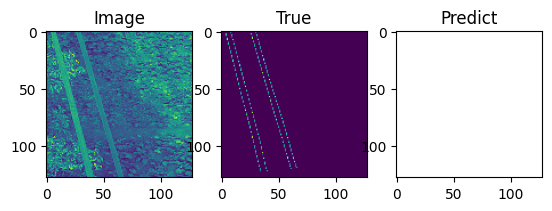

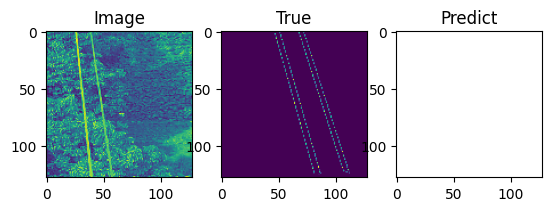

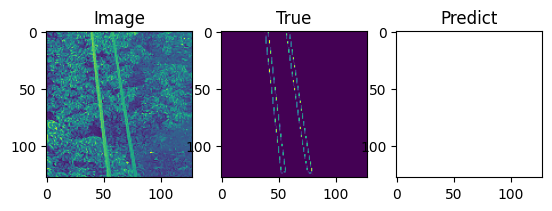

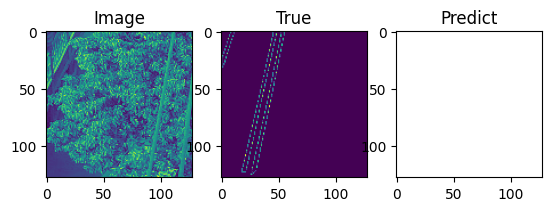

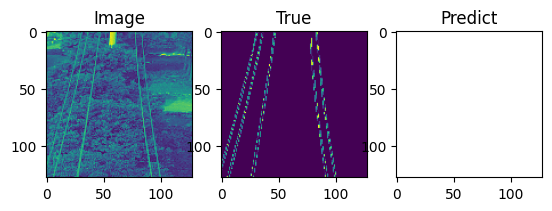

In [152]:
for x,y,pred in zip(X_train, y_train, y_train_pred):

    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.set_title("Image")
    ax1.imshow(x)
    ax2.set_title("True")
    ax2.imshow(y)
    ax3.set_title("Predict")
    ax3.imshow(pred)